In [1]:
%load_ext autoreload
%autoreload
%matplotlib widget
import importlib
from SOAEpeaks import load_df
import phaseco as pc
from phaseco import *
from tqdm import tqdm
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.signal.windows import gaussian
importlib.reload(pc)


<module 'phaseco' from 'c:\\Users\\Owner\\OneDrive\\Documents\\GitHub\\phase-coherence\\phaseco\\__init__.py'>

In [2]:


# Get different species
df = load_df(laptop=True, dfs_to_load=["Curated Data"])
wf_list = []
for species in ['Anolis', 'Owl', 'Human']:
    df_species = df[df['species'] == species]
    for i in range (3):
        row = df_species.iloc[i]
        wf_fn = row['filepath'].split('\\')[-1]
        wf_list.append((row['wf'], row['sr'], wf_fn, species))
del df

Loading Curated Data
Combining into one Dataframe!


In [197]:
wf_idx = 2 # Started with 0, 2 (Lizard) - 4, 5 (Owl) - 6, 7 (Human)

wf, fs, wf_fn, species = wf_list[wf_idx]

# Set parameters (same for human and lizard)
tau = 2**11 / 44100 # Everyone uses the same tau
tauS = int(tau*fs)
# Raise warning if tauS is not a power of two AND the samplerate is indeed 44100
if np.log2(tauS) != int(np.log2(tauS)):
    if fs == 44100:
        raise ValueError("tauS is not a power of 2, but the samplerate is 44100!")
    else:
        print(f"WARNING: tauS is not a power of 2, but the samplerate is {fs} (not 44100), so we'll assume you're just ensuring tau aligns with other waveforms!")

rho_beta = 0.1

if species == 'Human':
    # Human parameters
    min_xi = 0.0025
    max_xi = 1
    delta_xi = 0.001
    if wf_fn == 'human_TH14RearwaveformSOAE.mat':
        max_xi = 2.5
    max_khz = 6
elif species in ['Lizard', 'Anolis']:
    # Lizard parameters
    min_xi = 0.0025
    max_xi = 0.1
    delta_xi = 0.0005
    max_khz = 6
elif species == 'Owl':
    # Owl parameters
    min_xi = 0.0025
    max_xi = 0.1
    delta_xi = 0.0005
    max_khz = 12

In [208]:

# Calculate colossogram (if needed)
if 1:
    operation = 'generate+save'
else:
    operation = 'open'

rho_beta = 1
xis_power = 1
if operation == 'generate+save':
    num_xis = int((max_xi - min_xi) / delta_xi) + 1
    xis = np.linspace(min_xi, max_xi, num_xis)
    betas = rho_beta / (xis**(xis_power))
    print(f"betas = {betas}")
    max_xiS = max(xis) * fs
    f = rfftfreq(tauS, 1/fs)
    # Make sure we have a consistent number of segments to take vector strenght over since this will change with xi
    N_segs = int((len(wf) - tauS) / max_xiS)    
    coherences = np.zeros((len(f), len(xis)))
    print(f"Calculating coherence for wf {wf_fn} with {len(xis)} xi values")
    for i, xi in enumerate(tqdm(xis)):
        coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, win_type=('kaiser', betas[i]))[1]

betas = [400.         333.33333333 285.71428571 250.         222.22222222
 200.         181.81818182 166.66666667 153.84615385 142.85714286
 133.33333333 125.         117.64705882 111.11111111 105.26315789
 100.          95.23809524  90.90909091  86.95652174  83.33333333
  80.          76.92307692  74.07407407  71.42857143  68.96551724
  66.66666667  64.51612903  62.5         60.60606061  58.82352941
  57.14285714  55.55555556  54.05405405  52.63157895  51.28205128
  50.          48.7804878   47.61904762  46.51162791  45.45454545
  44.44444444  43.47826087  42.55319149  41.66666667  40.81632653
  40.          39.21568627  38.46153846  37.73584906  37.03703704
  36.36363636  35.71428571  35.0877193   34.48275862  33.89830508
  33.33333333  32.78688525  32.25806452  31.74603175  31.25
  30.76923077  30.3030303   29.85074627  29.41176471  28.98550725
  28.57142857  28.16901408  27.77777778  27.39726027  27.02702703
  26.66666667  26.31578947  25.97402597  25.64102564  25.3164557
  25.    

100%|██████████| 196/196 [00:55<00:00,  3.55it/s]


In [209]:
# Save/open coherences
suptitle=rf"[{wf_fn}]   [$\rho_{{\beta}}$={rho_beta}]   [$\xi$ power={xis_power}]   [$\tau$={tau*1000:.2f}ms]" 
fn_id = rf"tau={tau*1000:.0f}, rho_beta={rho_beta}, xis_power={xis_power}, {species}, {wf_fn.split('.')[0]}"
pkl_fn = f'C_xi_beta Decay Coherences - {fn_id}'
pkl_folder = r'Pickles/'
fig_folder = r'Colossogram Figures/C_xi_beta Decay Figures/'

if operation == 'generate+save':
    with open(pkl_folder + pkl_fn + '.pkl', 'wb') as file:
        pickle.dump((coherences, f, xis, tau, rho_beta, wf_fn, species), file)
elif operation == 'open':
    with open(pkl_folder + pkl_fn + '.pkl', 'rb') as file:
        coherences, f, xis, tau, rho_beta, wf_fn, species = pickle.load(file)

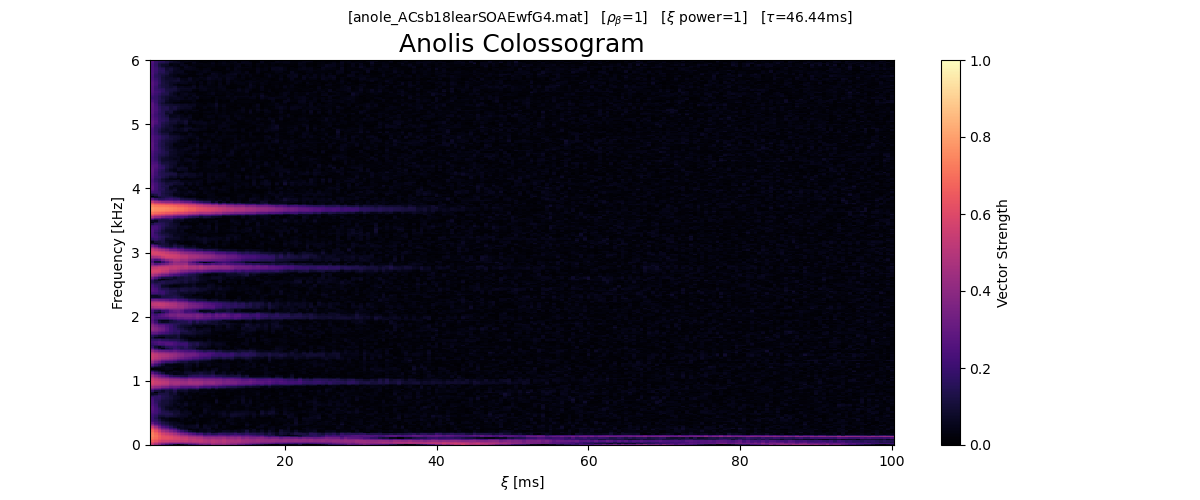

In [210]:
# Visualize colossogram
plt.close('all')
plt.figure(figsize=(12, 5))
plot_colossogram(coherences, f, xis, tau, max_khz=max_khz, cmap='magma')
plt.title(f"{species} Colossogram", fontsize=18)
plt.suptitle(suptitle, fontsize=10)
plt.savefig(f'{fig_folder}C_xi_beta Colossogram - {fn_id}.png', dpi=300)
plt.show()

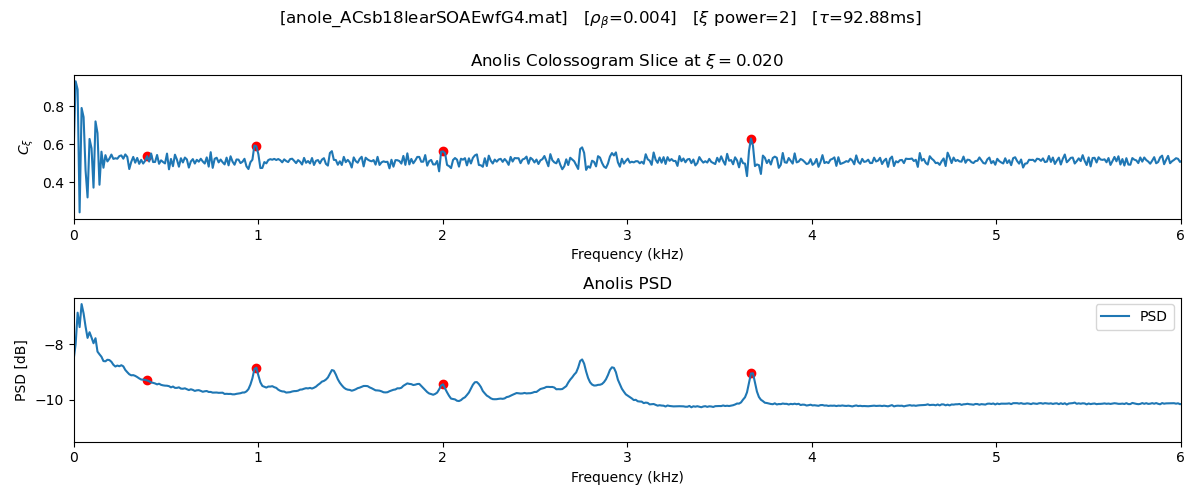

In [194]:
# Plot a slice of the colossogram with target bins marked
target_xi = 0.02
xi_idx = np.argmin(np.abs(xis - target_xi))
coherence_slice = coherences[:, xi_idx]
psd = get_welch(wf=wf, fs=fs, tauS=tauS)[1]
# psd_xi = get_welch(wf=wf, fs=fs, tauS=tauS, xi=target_xi)[1]

if wf_fn == 'anole_AC6rearSOAEwfB1.mat': # 0
    peak_freqs = [1225, 2150, 4300]
    noise_freqs = [400, 12000]
elif wf_fn == 'anole_ACsb18learSOAEwfG4.mat': # 2
    peak_freqs = [990, 2000, 3670]
    noise_freqs = [400, 12000]
elif wf_fn == 'owl_Owl6L1.mat': # 4
    peak_freqs = [4867, 6384, 7235]
    noise_freqs = [400, 12000]
elif wf_fn == 'owl_TAG4learSOAEwf1.mat': # 5
    peak_freqs = [6280, 7820, 10487]
    noise_freqs = [400, 12000]
elif wf_fn == 'human_TH14RearwaveformSOAE.mat': # 6
    peak_freqs = [603, 2250, 4370]
    noise_freqs = [400, 12000]
elif wf_fn == 'human_TH21RearwaveformSOAE.mat': # 7
    peak_freqs = [2000, 2605, 4135]
    noise_freqs = [400, 12000]
else:
    raise(Exception("Haven't peak picked this waveform yet!"))
    

bin_idxs = []
bin_names = []

for peak_freq in peak_freqs:
    bin_idxs.append(np.argmin(np.abs(f - peak_freq)))
    bin_names.append(f"{peak_freq:.0f}Hz Peak")

for noise_freq in noise_freqs:
    bin_idxs.append(np.argmin(np.abs(f - noise_freq)))
    bin_names.append(f"{noise_freq:.0f}Hz Noise")
    
freq_list = peak_freqs + noise_freqs
plt.close('all')
plt.figure(figsize=(12, 5))
plt.suptitle(suptitle)
plt.subplot(2, 1, 1)
plt.title(rf"{species} Colossogram Slice at $\xi={xis[xi_idx]:.3f}$")
plt.plot(f / 1000, coherence_slice)
for freq, idx in zip(freq_list, bin_idxs):
    plt.scatter(f[idx] / 1000, coherence_slice[idx], c='r')
plt.xlabel("Frequency (kHz)")
plt.ylabel(r'$C_{\xi}$')
plt.xlim(0, max_khz)
plt.subplot(2, 1, 2)
plt.title(rf"{species} PSD")
plt.plot(f / 1000, np.log10(psd), label='PSD')
#plt.plot(f / 1000, np.log10(psd_xi), label=r'PSD ($\xi$)')
for freq, idx in zip(freq_list, bin_idxs):
    plt.scatter(f[idx] / 1000, np.log10(psd[idx]), c='r')
    #plt.scatter(f[idx] / 1000, np.log10(psd_xi[idx]), c='r')
plt.xlabel("Frequency (kHz)")
plt.ylabel("PSD [dB]")  
plt.legend()
plt.xlim(0, max_khz)
plt.tight_layout()
plt.savefig(f'{fig_folder}C_xi_beta Decay Target Bins - {fn_id}.png', dpi=300)
plt.show()

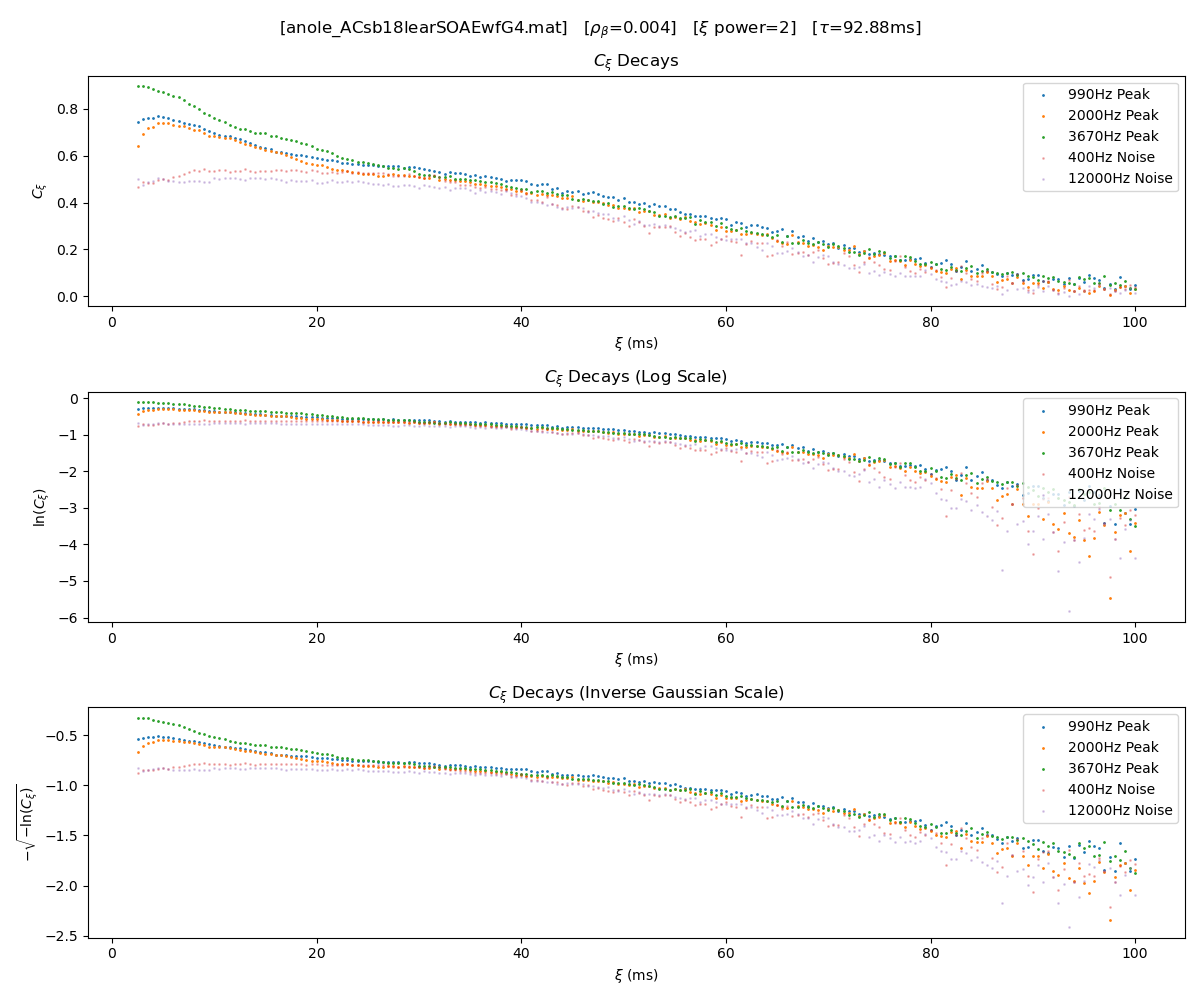

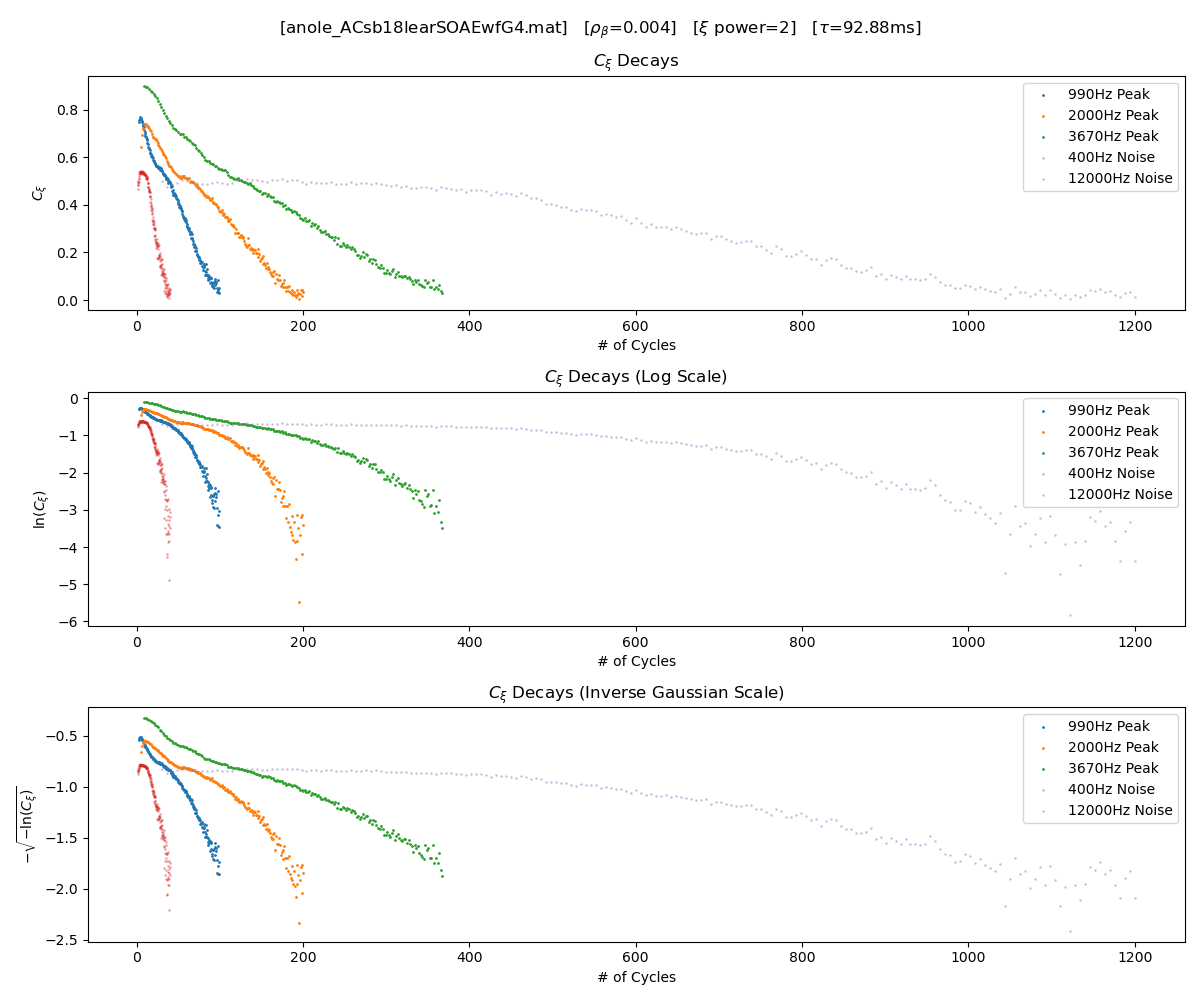

In [195]:

# Plot decays on various scales

s=1

for xscale_str in ['Xi', '# Cycles']:
    plt.figure(figsize=(12, 10))
    plt.suptitle(suptitle)
    for scale, idx in zip(['normal', 'log', 'gauss'], [1, 2, 3]):
        plt.subplot(3, 1, idx)
        for f_idx, bin_name in zip(bin_idxs, bin_names):
            coherence_falloff = coherences[f_idx, :]
            title = r"$C_{\xi}$ Decays"
            if scale == 'normal':
                plt.ylabel(r'$C_{\xi}$')
            if scale == 'gauss':
                coherence_falloff = -np.sqrt(-np.log(coherence_falloff))
                plt.ylabel(r'$-\sqrt{-\ln(C_{\xi})}$')
                title+= " (Inverse Gaussian Scale)"
            elif scale == 'log':
                coherence_falloff = np.log(coherence_falloff)
                plt.ylabel(r'$\ln(C_{\xi})$')
                plt.title("Log Scale")
                title+= " (Log Scale)"            
            plt.title(title)
            alpha=1
            if 'Noise' in bin_name:
                alpha=0.3
            if xscale_str == '# Cycles':
                x = xis * f[f_idx] # Nondimensionalize
                xlabel = '# of Cycles'
            else:
                x = xis*1000
                xlabel = r'$\xi$ (ms)'
            plt.scatter(x, coherence_falloff, label=bin_name, alpha=alpha, s=s)
        plt.xlabel(xlabel)
        plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f'{fig_folder}C_xi_beta Decay Scales - {xscale_str} - {fn_id}.png', dpi=300)
    plt.show()


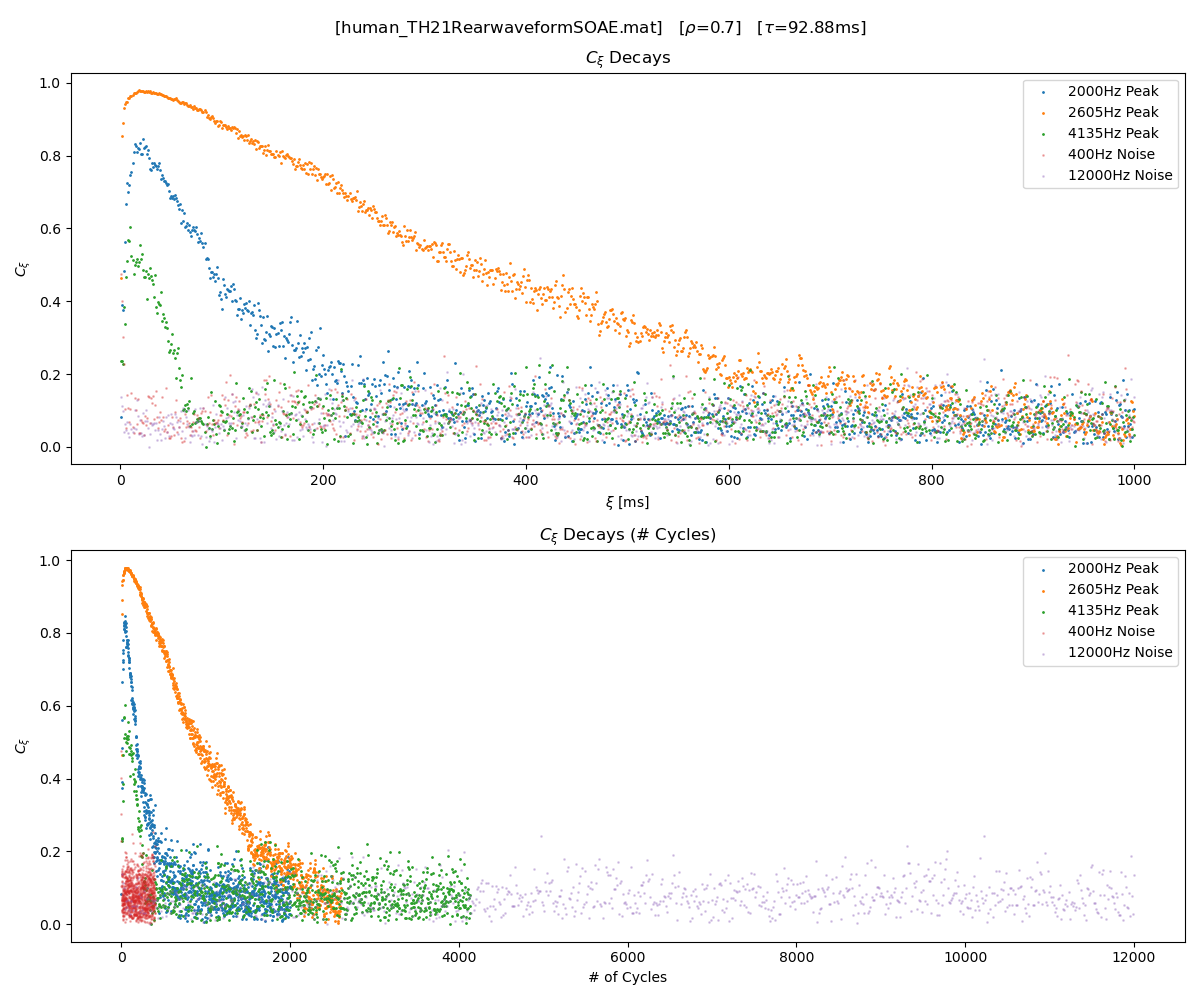

In [ ]:
# Compare xi scale vs # cycles scale
plt.figure(figsize=(12, 10))
plt.suptitle(suptitle)

# Xi scale
plt.subplot(2, 1, 1)
title = r"$C_{\xi}$ Decays"
for f_idx, bin_name in zip(bin_idxs, bin_names):
    coherence_falloff = coherences[f_idx, :]    
    plt.ylabel(r'$C_{\xi}$')           
    plt.title(title)
    alpha=1
    if 'Noise' in bin_name:
        alpha=0.3
    plt.scatter(xis*1000, coherence_falloff, label=bin_name, alpha=alpha, s=s)
plt.xlabel(r'$\xi$ [ms]')
plt.legend()

# Num Cycles scale
plt.subplot(2, 1, 2)
title = r"$C_{\xi}$ Decays (# Cycles)"
for f_idx, bin_name in zip(bin_idxs, bin_names):
    coherence_falloff = coherences[f_idx, :]
 
    nums_cycles = xis * f[f_idx] # Nondimensionalize
    plt.ylabel(r'$C_{\xi}$')           
    plt.title(title)
    alpha=1
    if 'Noise' in bin_name:
        alpha=0.3
    plt.scatter(nums_cycles, coherence_falloff, label=bin_name, alpha=alpha, s=s)
plt.xlabel(r'# of Cycles')
plt.legend()

# Book it!
plt.tight_layout()
plt.savefig(f'{fig_folder}C_xi_beta Decays Xi vs # Cycles - {fn_id}.png', dpi=300)
plt.show()
    



In [ ]:

# # tauS = int(tau*fs/10)
# # Calculate colossogram (if needed)
# if 1:
#     operation = 'generate+save'
# else:
#     operation = 'open'

# if operation == 'generate+save':
#     num_xis = int((max_xi - min_xi) / delta_xi) + 1
#     xis = np.linspace(min_xi, max_xi, num_xis)

#     max_xiS = max(xis) * fs
#     f = rfftfreq(tauS, 1/fs)
#     # Make sure we have a consistent number of segments to take vector strenght over since this will change with xi
#     N_segs = int((len(wf) - tauS) / max_xiS)    

#     coherences = np.zeros((len(f), len(xis)))
#     print(f"Calculating coherence for wf {wf_fn} with {len(xis)} xi values")
#     plt.close('all')
#     print(xis[0])
#     for i, xi in enumerate(tqdm(xis)):
#         if i < 1:
#             continue
#         rho_beta=0.015
#         beta = rho_beta / xi**2
#         beta=6
#         print(beta)
#         win = get_window(('kaiser', beta), tauS)
#         print(tauS)
#         t = np.linspace(0, tauS/fs*1000, tauS)
#         plt.plot(t, win, ls = '--', label="Kaiser")
#         plt.plot(t + xi*1000, win, ls = '--', label="Kaiser")
#         plt.legend()
#         plt.show()
#         break
#         # break
#         # coherences[:, i] = get_coherence(wf=wf, fs=fs, tauS=tauS, xi=xi, ref_type="next_seg", N_segs=N_segs, win_type=('kaiser', beta))[1]